In [1]:
import os
import pandas as pd
import numpy as np
import math
import gensim
import random
from itertools import chain
import torch
import dgl
import dgl.function as fn
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report,f1_score,accuracy_score,recall_score,precision_score
from gensim.models import KeyedVectors
import re
from itertools import combinations
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pickle
from tokenizers import  BertWordPieceTokenizer
from transformers import BertTokenizer,BertModel
from pytorchtools import EarlyStopping
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pytorchtools import EarlyStopping

Using backend: pytorch


In [2]:
LABELS = 3
MAX_LENGTH =  38 
PIXEL = 49
BATCH_SIZE = 32
DEVICE = 'cuda:0'
WINDOWS = 2
NB_EPOCH = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


## build graph

In [3]:

def get_batch_graph(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len)
        # A couple edges one-by-one
        for j in range(windows,max_len+1):
            t = range(j-windows,j)
            edges = np.array(list(combinations(t,2)))
            for edge in edges:
                g.add_edges(edge[0],edge[1])
                g.add_edge(edge[1], edge[0])
#         g.add_edge(max_length -1, 0)

        batch_graph.append(g)
    return batch_graph

def get_fusion_batch(batch_size,max_len,pixel):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len + pixel)
    
        # text with pixel
        for j in range(max_len,max_len + pixel):
            for i in range(0,max_len):
                g.add_edges(i,j)
                g.add_edge(j, i)
        
        batch_graph.append(g)
        
    return batch_graph
    


batch_graph = get_batch_graph(BATCH_SIZE, MAX_LENGTH, WINDOWS)
batch_fusion_graph = get_fusion_batch(BATCH_SIZE, MAX_LENGTH, PIXEL)

def get_next_batch(batch_size,batch_graph = batch_graph):
    batch_graph = batch_graph[0:batch_size]
    bg = dgl.batch(batch_graph, edge_attrs=None)
    bg = bg.to(torch.device(DEVICE))
    return bg

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


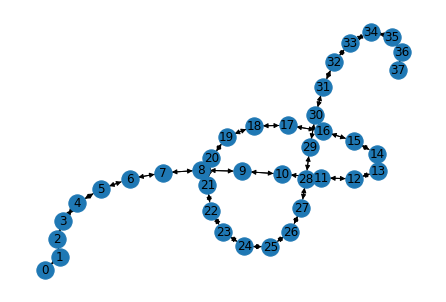

In [4]:

import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


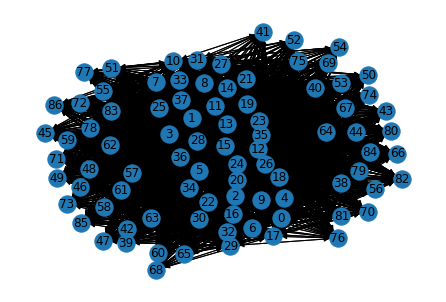

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_fusion_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


In [6]:
def load_data():
    
    images = torch.load('./dataset/twitter26k/images.pkl')
    texts = torch.load('./dataset/twitter26k/text.pkl')
    texts = [text.strip().lower().replace('#',' # ') for text in texts]
    y = torch.load('./dataset/twitter26k/y.pkl')
    
    return texts,images,y


def get_token_text(texts,max_length):
    pad = np.array([102] * max_length)
    texts_tmp = []

    for t  in texts:
        token = tokenizer(t,return_tensors = 'pt')['input_ids'].numpy()[0]
        if len(token)>= max_length:
            token = token[0:max_length]
        else:
            token = np.concatenate((token,pad[0:max_length-len(token)])) 
        token = np.reshape(token,(1,-1))
        if len(texts_tmp)==0:
            texts_tmp = token
        else:
            texts_tmp = np.vstack((texts_tmp,token))

    x_texts  = texts_tmp   
    
    return x_texts

def get_data_loader(shuffle_index,fold_index,fold_N = 10):
    fold_sample_num = len(shuffle_index)//fold_N
    test_index = shuffle_index[fold_sample_num * fold_index : fold_sample_num * (fold_index+1)]
    train_val_index = np.concatenate((shuffle_index[0:fold_sample_num * fold_index],shuffle_index[fold_sample_num * (fold_index+1):])).astype(int)
    train_index = train_val_index[0: -fold_sample_num]
    val_index = train_val_index[-fold_sample_num:]
    
    print('test_index:{begin}==>{end}'.format(begin = fold_sample_num * fold_index,end =  fold_sample_num * (fold_index+1)))


    
    train_texts = x_texts[train_index]
    train_images = images[train_index]
    train_y = y[train_index]
    
    val_texts = x_texts[val_index]
    val_images = images[val_index]
    val_y = y[val_index]
    
    test_texts = x_texts[test_index]
    test_images = images[test_index]
    test_y = y[test_index]

    train_set = data.TensorDataset(torch.LongTensor(train_texts),torch.FloatTensor(train_images) ,torch.LongTensor(train_y))
    val_set = data.TensorDataset(torch.LongTensor(val_texts),torch.FloatTensor(val_images), torch.LongTensor(val_y))
    test_set = data.TensorDataset(torch.LongTensor(test_texts),torch.FloatTensor(test_images), torch.LongTensor(test_y))

    train_data_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                             shuffle=True)
    val_data_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    test_data_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                            shuffle=False)
    
    return train_data_loader,val_data_loader,test_data_loader

texts,images,y = load_data()
x_texts = get_token_text(texts,MAX_LENGTH)


In [7]:
class GAT(nn.Module):
    def __init__(self, input_dim,output_dim, activation):
        super(GAT, self).__init__()
       
        self.norm = nn.BatchNorm1d(input_dim)
        self.merge_linner =  nn.Linear( input_dim , output_dim)
        self.activation = activation
        self.fc = nn.Linear(input_dim, input_dim, bias=False)
        self.attn_fc = nn.Linear(2 * input_dim, 1, bias=False)
    
    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(z2)
        return { 'e': F.leaky_relu(a)}
    
    def message_func(self, edges):
        return {'h': edges.src['h'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)  
        h_ = nodes.data['h']
#         # equation (4)
        h = torch.sum(alpha * nodes.mailbox['h'], dim=1)
        h = 0.9 * h + 0.1 * h_
        h = self.merge_linner(h)
        h = self.activation(h)
        
        return {'h': h}
    
    def forward(self, bg, h):

        # equation (1)
        h = self.fc(h)
        bg.ndata['h'] = h
        # equation (2)
        bg.apply_edges(self.edge_attention)
        # equation (3) & (4)
        bg.update_all(self.message_func, self.reduce_func)
        
        return bg.ndata.pop('h')
    

    
class SelfAttention(nn.Module):
    # refrence:https://blog.csdn.net/uhauha2929/article/details/81951760
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # (B, L, H) -> (B , L, 1)
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
#         print('weight',weights)
        # (B, L, H) * (B, L, 1) -> (B, H)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class Classifier(nn.Module):
    def __init__(self, labels,max_length,pixel,hidden_size = 768,drop_rate = 0.4):
        super(Classifier, self).__init__()
        self.labels = labels

        self.dropout = nn.Dropout(drop_rate)
        self.hidden_size = hidden_size
        self.bert_model = BertModel.from_pretrained('bert-base-uncased',return_dict = True)
        self.text_normal = nn.LayerNorm((max_length,self.hidden_size))
        self.image_normal = nn.LayerNorm((pixel,self.hidden_size))
        
        self.GAT = GAT(self.hidden_size, self.hidden_size, F.relu)
        self.att = SelfAttention(self.hidden_size)
        self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.image_trans = nn.Linear(1280, self.hidden_size)

        self.classify_h = nn.Linear(self.hidden_size , self.hidden_size)
        self.classify = nn.Linear(self.hidden_size, labels)

    def forward(self,text,image):
        
        bs = text.shape[0]
        bg = get_next_batch(bs)
        bg_fusion = get_next_batch(bs,batch_graph = batch_fusion_graph)
        
        text = self.bert_model(text).last_hidden_state
#         text = torch.reshape(text,(bs,-1,self.hidden_size))   #[bs,max_len,hidden_size]
        text = self.text_normal(text)
        with torch.no_grad():
            img = self.image_model.extract_features(image) #[bs,1280,7,7]  1536
        img = torch.reshape(img,(bs,1280,49))   #[bs,1280,49]
        img = torch.transpose(img,1,2)          #[bs,49,1280]
        img =  torch.reshape(img,(-1,1280))     #[bs*49,1280]
        img = self.image_trans(img)             #[bs*49,hidden_size]
        img = torch.reshape(img,(bs,-1,self.hidden_size))   #[bs,49,hidden_size]
#         img = self.image_normal(img)

        feature = torch.cat([text, img], 1)
        feature_short = torch.reshape(feature,(-1,feature.shape[2]))

        gat_feature = self.GAT(bg_fusion, feature_short)
#         head_feature = self.multi_head(gat_feature,bs)
        feature = feature_short + gat_feature
        feature = torch.reshape(feature,(bs,-1,feature.shape[-1]))
        feature = self.att(feature)
        
#         feature = torch.cat([feature_short, gat_feature,head_feature], 1)
#         feature = torch.reshape(feature,(bs,-1))
        feature = self.dropout(feature)
        
        feature = self.classify_h(feature)
        feature = F.relu(feature)
        
        return self.classify(feature)

    
def model_test(data_loader,model,report = False):
    '''
    使用验证集或测试集测试模型
    '''
    pred_Y = []
    test_Y = []
    loss_l = []
    loss_func = nn.CrossEntropyLoss()
    for step,(b_texts,b_image_features, test_y_batch) in enumerate(data_loader):

        
        b_texts = b_texts.to(torch.device(DEVICE))
        b_image_features = b_image_features.to(torch.device(DEVICE))
        test_y_batch = test_y_batch.to(torch.device(DEVICE))
        
        test_net_out = model(b_texts,b_image_features)
        loss = loss_func(test_net_out, test_y_batch) 
        loss_l.append(loss.cpu().data.numpy())
        
        test_net_out = test_net_out.cpu().data.numpy()
        pred_y_batch = np.argmax(test_net_out,axis = 1)
        pred_Y = np.concatenate((pred_Y,pred_y_batch), axis=0) 
        test_Y = np.concatenate((test_Y,test_y_batch.cpu().data.numpy()), axis=0)
    
    if report:
        print(classification_report(test_Y,pred_Y,digits = 5))
    f1_macro = f1_score(test_Y,pred_Y,average='macro')
    f1_weighted = f1_score(test_Y,pred_Y,average='weighted')
    acc = accuracy_score(test_Y,pred_Y)
    loss_mean = np.mean(np.array(loss_l))
    
    return f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean


def draw_cofusion_matrix(test_Y,pred_Y, labels=[0, 1, 2]):
    sns.set()
    
    plt.figure(figsize=(300, 300))
    f,ax=plt.subplots()
    C2= confusion_matrix(test_Y,pred_Y, labels=[0, 1, 2],normalize = 'true')
    print(C2) #打印出来看看
    sns.heatmap(C2,annot=True,ax=ax,cmap="YlGnBu") #画热力图

    labels = ['negative','neutral','positive']
    ax.set_title('confusion matrix') #标题
    ax.set_xticklabels( labels) 
    ax.set_yticklabels(labels) 
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    plt.show()

test_index:0==>2695
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.10
epoch:0, step:100, loss:0.45
epoch:0, step:200, loss:0.24
epoch:0, step:300, loss:0.26
epoch:0, step:400, loss:0.23
epoch:0, step:500, loss:0.09
epoch:0, step:600, loss:0.09
*** 0.9438006123533241 0.9550133492078445 0.9551020408163265
0.9494513265848253, best: 0.9494513265848253
epoch:1, step:0, loss:0.13
epoch:1, step:100, loss:0.02
epoch:1, step:200, loss:0.05
epoch:1, step:300, loss:0.06
epoch:1, step:400, loss:0.03
epoch:1, step:500, loss:0.05
epoch:1, step:600, loss:0.07
*** 0.9453808129074791 0.9567268795362845 0.9565862708719851
0.9509835418897321, best: 0.9509835418897321
epoch:2, step:0, loss:0.03
epoch:2, step:100, loss:0.02
epoch:2, step:200, loss:0.00
epoch:2, step:300, loss:0.09
epoch:2, step:400, loss:0.39
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.34
*** 0.9561194131292293 0.9654474646952477 0.9654916512059369
0.9608055321675831, best: 0.9608055321675831
epoch:3, step

<Figure size 21600x21600 with 0 Axes>

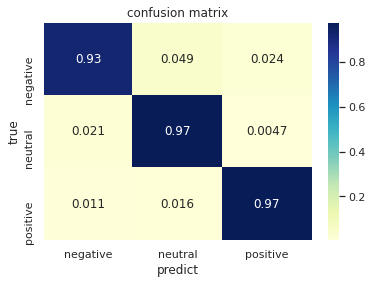

test_index:2695==>5390
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.13
epoch:0, step:100, loss:0.48
epoch:0, step:200, loss:0.17
epoch:0, step:300, loss:0.18
epoch:0, step:400, loss:0.29
epoch:0, step:500, loss:0.18
epoch:0, step:600, loss:0.29
*** 0.9442398908716344 0.9563379554959164 0.9562152133580705
0.9502275521148524, best: 0.9502275521148524
epoch:1, step:0, loss:0.05
epoch:1, step:100, loss:0.03
epoch:1, step:200, loss:0.05
epoch:1, step:300, loss:0.01
epoch:1, step:400, loss:0.02
epoch:1, step:500, loss:0.16
epoch:1, step:600, loss:0.06
*** 0.9533674887744152 0.9625499208444293 0.9625231910946197
0.9579453399345175, best: 0.9579453399345175
epoch:2, step:0, loss:0.01
epoch:2, step:100, loss:0.00
epoch:2, step:200, loss:0.01
epoch:2, step:300, loss:0.01
epoch:2, step:400, loss:0.01
epoch:2, step:500, loss:0.10
epoch:2, step:600, loss:0.02
*** 0.9531048777005625 0.9636662735229177 0.9636363636363636
0.958370620668463, best: 0.958370620668463
EarlyStoppin

<Figure size 21600x21600 with 0 Axes>

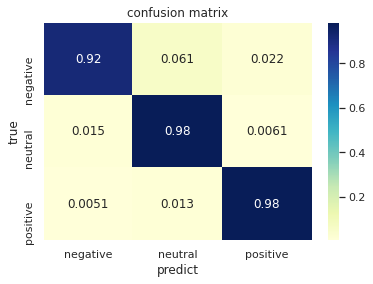

test_index:5390==>8085
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.11
epoch:0, step:100, loss:0.30
epoch:0, step:200, loss:0.39
epoch:0, step:300, loss:0.14
epoch:0, step:400, loss:0.27
epoch:0, step:500, loss:0.09
epoch:0, step:600, loss:0.10
*** 0.9360477224073196 0.9503697104079122 0.9499072356215214
0.9429774790144205, best: 0.9429774790144205
epoch:1, step:0, loss:0.09
epoch:1, step:100, loss:0.09
epoch:1, step:200, loss:0.16
epoch:1, step:300, loss:0.10
epoch:1, step:400, loss:0.03
epoch:1, step:500, loss:0.25
epoch:1, step:600, loss:0.13
*** 0.9433926497605937 0.9554102955461563 0.9551020408163265
0.9492473452884601, best: 0.9492473452884601
epoch:2, step:0, loss:0.03
epoch:2, step:100, loss:0.01
epoch:2, step:200, loss:0.48
epoch:2, step:300, loss:0.01
epoch:2, step:400, loss:0.03
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.01
*** 0.9509053992896469 0.9607024745301392 0.9606679035250464
0.9557866514073466, best: 0.9557866514073466
epoch:3, s

<Figure size 21600x21600 with 0 Axes>

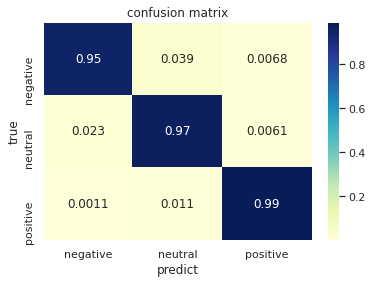

test_index:8085==>10780
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.09
epoch:0, step:100, loss:0.50
epoch:0, step:200, loss:0.35
epoch:0, step:300, loss:0.15
epoch:0, step:400, loss:0.21
epoch:0, step:500, loss:0.15
epoch:0, step:600, loss:0.03
*** 0.9375432027165275 0.9516851439427518 0.9510204081632653
0.9442818054398964, best: 0.9442818054398964
epoch:1, step:0, loss:0.16
epoch:1, step:100, loss:0.04
epoch:1, step:200, loss:0.26
epoch:1, step:300, loss:0.20
epoch:1, step:400, loss:0.21
epoch:1, step:500, loss:0.03
epoch:1, step:600, loss:0.01
*** 0.9495424463254672 0.9607723730025012 0.961038961038961
0.9552907036822141, best: 0.9552907036822141
epoch:2, step:0, loss:0.24
epoch:2, step:100, loss:0.01
epoch:2, step:200, loss:0.01
epoch:2, step:300, loss:0.05
epoch:2, step:400, loss:0.13
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.02
*** 0.9463350786960133 0.9586989593978393 0.9584415584415584
0.9523883185687858, best: 0.9552907036822141
EarlyStopp

<Figure size 21600x21600 with 0 Axes>

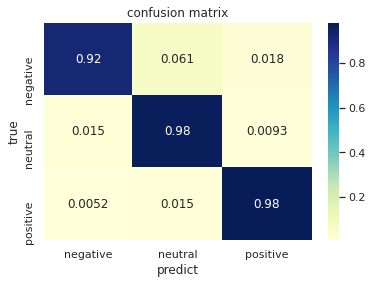

test_index:10780==>13475
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.10
epoch:0, step:100, loss:0.41
epoch:0, step:200, loss:0.13
epoch:0, step:300, loss:0.21
epoch:0, step:400, loss:0.04
epoch:0, step:500, loss:0.18
epoch:0, step:600, loss:0.41
*** 0.936204625567277 0.9483684061928631 0.948051948051948
0.9421282868096126, best: 0.9421282868096126
epoch:1, step:0, loss:0.13
epoch:1, step:100, loss:0.28
epoch:1, step:200, loss:0.09
epoch:1, step:300, loss:0.10
epoch:1, step:400, loss:0.22
epoch:1, step:500, loss:0.05
epoch:1, step:600, loss:0.02
*** 0.9503497207899724 0.9614711221180224 0.9614100185528757
0.955879869671424, best: 0.955879869671424
epoch:2, step:0, loss:0.04
epoch:2, step:100, loss:0.00
epoch:2, step:200, loss:0.03
epoch:2, step:300, loss:0.03
epoch:2, step:400, loss:0.03
epoch:2, step:500, loss:0.02
epoch:2, step:600, loss:0.22
*** 0.948498976384719 0.96006456571009 0.9602968460111317
0.9543979111979254, best: 0.955879869671424
EarlyStopping co

<Figure size 21600x21600 with 0 Axes>

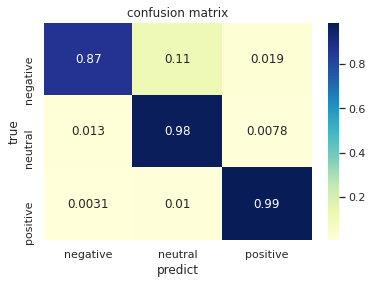

test_index:13475==>16170
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.11
epoch:0, step:100, loss:0.50
epoch:0, step:200, loss:0.40
epoch:0, step:300, loss:0.16
epoch:0, step:400, loss:0.11
epoch:0, step:500, loss:0.25
epoch:0, step:600, loss:0.05
*** 0.9448697463736888 0.9568876982765913 0.9569573283858999
0.9509135373797943, best: 0.9509135373797943
epoch:1, step:0, loss:0.04
epoch:1, step:100, loss:0.11
epoch:1, step:200, loss:0.12
epoch:1, step:300, loss:0.04
epoch:1, step:400, loss:0.03
epoch:1, step:500, loss:0.16
epoch:1, step:600, loss:0.02
*** 0.9538745637702783 0.9631853002036348 0.963265306122449
0.9585699349463637, best: 0.9585699349463637
epoch:2, step:0, loss:0.08
epoch:2, step:100, loss:0.01
epoch:2, step:200, loss:0.01
epoch:2, step:300, loss:0.01
epoch:2, step:400, loss:0.02
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.01
*** 0.9478700489683188 0.9593288573762455 0.9595547309833025
0.9537123899758106, best: 0.9585699349463637
EarlyStop

<Figure size 21600x21600 with 0 Axes>

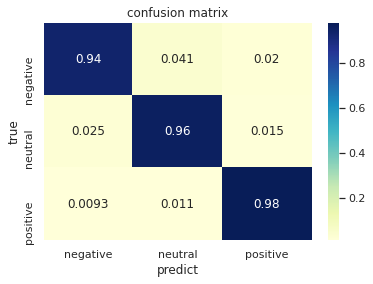

test_index:16170==>18865
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.12
epoch:0, step:100, loss:0.39
epoch:0, step:200, loss:0.32
epoch:0, step:300, loss:0.17
epoch:0, step:400, loss:0.17
epoch:0, step:500, loss:0.13
epoch:0, step:600, loss:0.11
*** 0.941723610099907 0.9544050582307253 0.9547309833024119
0.9482272967011595, best: 0.9482272967011595
epoch:1, step:0, loss:0.18
epoch:1, step:100, loss:0.04
epoch:1, step:200, loss:0.05
epoch:1, step:300, loss:0.29
epoch:1, step:400, loss:0.22
epoch:1, step:500, loss:0.02
epoch:1, step:600, loss:0.19
*** 0.9381164759887012 0.9520424549360955 0.9513914656771799
0.9447539708329405, best: 0.9482272967011595
epoch:2, step:0, loss:0.02
epoch:2, step:100, loss:0.02
epoch:2, step:200, loss:0.02
epoch:2, step:300, loss:0.01
epoch:2, step:400, loss:0.24
epoch:2, step:500, loss:0.20
epoch:2, step:600, loss:0.19
*** 0.9543479094339741 0.9642934112879543 0.9643784786641929
0.9593631940490834, best: 0.9593631940490834
EarlyStop

<Figure size 21600x21600 with 0 Axes>

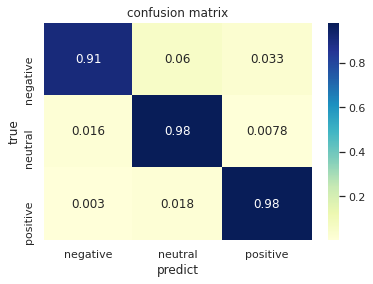

test_index:18865==>21560
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.12
epoch:0, step:100, loss:0.50
epoch:0, step:200, loss:0.18
epoch:0, step:300, loss:0.48
epoch:0, step:400, loss:0.09
epoch:0, step:500, loss:0.32
epoch:0, step:600, loss:0.10
*** 0.9401750185895117 0.9522457738140413 0.952504638218924
0.9463398284042178, best: 0.9463398284042178
epoch:1, step:0, loss:0.08
epoch:1, step:100, loss:0.32
epoch:1, step:200, loss:0.03
epoch:1, step:300, loss:0.09
epoch:1, step:400, loss:0.03
epoch:1, step:500, loss:0.16
epoch:1, step:600, loss:0.12
*** 0.9545558415735161 0.9634305488168033 0.963265306122449
0.9589105738479826, best: 0.9589105738479826
epoch:2, step:0, loss:0.02
epoch:2, step:100, loss:0.03
epoch:2, step:200, loss:0.04
epoch:2, step:300, loss:0.02
epoch:2, step:400, loss:0.03
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.02
*** 0.9559348635272545 0.9643005538573247 0.9643784786641929
0.9601566710957237, best: 0.9601566710957237
EarlyStopp

<Figure size 21600x21600 with 0 Axes>

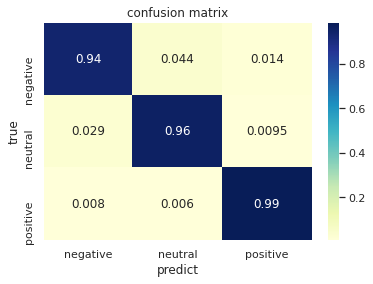

test_index:21560==>24255
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.09
epoch:0, step:100, loss:0.50
epoch:0, step:200, loss:0.67
epoch:0, step:300, loss:0.16
epoch:0, step:400, loss:0.25
epoch:0, step:500, loss:0.46
epoch:0, step:600, loss:0.30
*** 0.941402150525045 0.95265284095354 0.952504638218924
0.9469533943719844, best: 0.9469533943719844
epoch:1, step:0, loss:0.04
epoch:1, step:100, loss:0.16
epoch:1, step:200, loss:0.04
epoch:1, step:300, loss:0.33
epoch:1, step:400, loss:0.07
epoch:1, step:500, loss:0.13
epoch:1, step:600, loss:0.04
*** 0.9556328620782786 0.9645734746865183 0.9647495361781077
0.9601911991281931, best: 0.9601911991281931
epoch:2, step:0, loss:0.03
epoch:2, step:100, loss:0.01
epoch:2, step:200, loss:0.00
epoch:2, step:300, loss:0.02
epoch:2, step:400, loss:0.03
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.03
*** 0.9412661275868907 0.9544108104334015 0.9539888682745825
0.9476274979307366, best: 0.9601911991281931
EarlyStoppin

<Figure size 21600x21600 with 0 Axes>

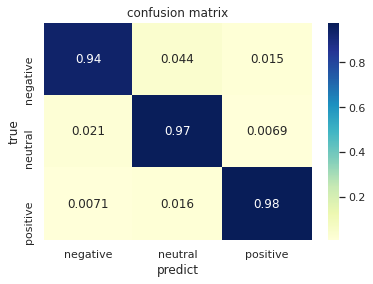

test_index:24255==>26950
Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.13
epoch:0, step:100, loss:0.59
epoch:0, step:200, loss:0.33
epoch:0, step:300, loss:0.17
epoch:0, step:400, loss:0.21
epoch:0, step:500, loss:0.10
epoch:0, step:600, loss:0.24
*** 0.9348183512370443 0.9489896375003066 0.948051948051948
0.9414351496444961, best: 0.9414351496444961
epoch:1, step:0, loss:0.06
epoch:1, step:100, loss:0.07
epoch:1, step:200, loss:0.05
epoch:1, step:300, loss:0.02
epoch:1, step:400, loss:0.08
epoch:1, step:500, loss:0.19
epoch:1, step:600, loss:0.09
*** 0.9571042456437956 0.966857937604125 0.9666048237476809
0.9618545346957382, best: 0.9618545346957382
epoch:2, step:0, loss:0.01
epoch:2, step:100, loss:0.01
epoch:2, step:200, loss:0.03
epoch:2, step:300, loss:0.01
epoch:2, step:400, loss:0.05
epoch:2, step:500, loss:0.01
epoch:2, step:600, loss:0.01
*** 0.9515532226375498 0.9631715601170414 0.9628942486085343
0.9572237356230421, best: 0.9618545346957382
EarlyStopp

<Figure size 21600x21600 with 0 Axes>

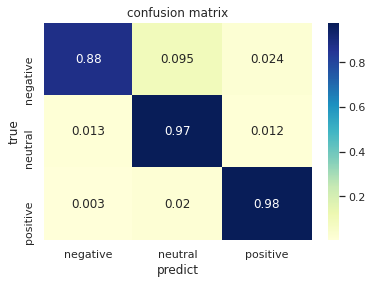

[0.9573852795515795, 0.9613445004041102, 0.9687552510322464, 0.9614147559601866, 0.9524821342142994, 0.9560134788204054, 0.9578273995032706, 0.9586387535400056, 0.961270926005137, 0.9513688415683547]
[0.9659178614600268, 0.9702369710555321, 0.9744633499160663, 0.9683772325320732, 0.9635737742658487, 0.9637424984257915, 0.9664611881537388, 0.9675183307696991, 0.9692930197577384, 0.9607534354931834]
[0.9658627087198516, 0.9703153988868275, 0.9743970315398887, 0.9684601113172542, 0.9640074211502783, 0.9636363636363636, 0.9666048237476809, 0.9673469387755103, 0.9692022263450835, 0.961038961038961]
max macro_f1:0.9687552510322464, max weight_f1:0.9744633499160663,max acc:0.9743970315398887
min macro_f1:0.9513688415683547, min weight_f1:0.9607534354931834,min acc:0.961038961038961
mean macro_f1:0.9586501320599595, mean weight_f1:0.9670337661829699,mean acc:0.96708719851577


In [8]:
shuffle_index = list(range(len(y)))
# random.Random(1337).shuffle(shuffle_index) 

f1_macro_list = []
f1_weighted_list = []
acc_list = []


for fold in range(10):
    begin = time.time()
    
    train_data_loader,val_data_loader,test_data_loader = get_data_loader(shuffle_index,fold)
    
    early_stopping = EarlyStopping( delta=1e-4, patience=3)
    
    #构造模型 
    net = Classifier(labels=LABELS,max_length = MAX_LENGTH,pixel = PIXEL)
    net.to(torch.device(DEVICE))


    optimizer = torch.optim.Adam(params = net.parameters(),
                                 lr = 2e-5)

    loss_func = nn.CrossEntropyLoss()

    import time
    max_acc = 0
    # training and testing
    for epoch in range(NB_EPOCH):
        net.train()
        for step, (b_texts,b_image_features, b_y) in enumerate(train_data_loader):        # gives batch data
            b_texts = b_texts.to(torch.device(DEVICE))
            b_image_features = b_image_features.to(torch.device(DEVICE))
            b_y = b_y.to(torch.device(DEVICE))


            out = net(b_texts,b_image_features)                               # rnn output
            loss = loss_func(out, b_y) 
            if step %100 ==0:
                print('epoch:%d, step:%d, loss:%.2f'%(epoch,step,loss.cpu().data.numpy()))
            optimizer.zero_grad()                           # clear gradients for this training step
            loss.backward()                                 # backpropagation, compute gradients
            optimizer.step()                                # apply gradients

        net.eval()
        #每训练一轮，使用验证集验证
        f1_macro,f1_weighted,acc,test_Y,pred_Y,val_loss = model_test(val_data_loader,net)

        print('***',f1_macro,f1_weighted,acc)

        acc = (f1_macro+acc)/2
        if acc >max_acc:
            max_acc = acc
            torch.save(net, 'best_twitter.pkl')
        print('{acc}, best: {max_acc}'.format(acc = acc,max_acc = max_acc))
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    print('run time:',time.time()-begin)
    
    net = torch.load('best_twitter.pkl')
    net.eval()
    
    f1_macro,f1_weighted,acc,test_Y,pred_Y,loss_mean = model_test(test_data_loader, net,report = True)

    print('----***----',f1_macro,f1_weighted,acc)
    f1_macro_list.append(f1_macro)
    f1_weighted_list.append(f1_weighted)
    acc_list.append(acc)
    draw_cofusion_matrix(test_Y,pred_Y)

print(f1_macro_list)
print(f1_weighted_list)
print(acc_list)
print('max macro_f1:{macro_f1}, max weight_f1:{weight_f1},max acc:{acc}'.format(
    macro_f1 = max(f1_macro_list),weight_f1 = max(f1_weighted_list),acc = max(acc_list)))
print('min macro_f1:{macro_f1}, min weight_f1:{weight_f1},min acc:{acc}'.format(
    macro_f1 = min(f1_macro_list),weight_f1 = min(f1_weighted_list),acc = min(acc_list)))
print('mean macro_f1:{macro_f1}, mean weight_f1:{weight_f1},mean acc:{acc}'.format(
    macro_f1 = np.mean(f1_macro_list),weight_f1 = np.mean(f1_weighted_list),acc = np.mean(acc_list)))

    